## Analysis of Train to Busan (2020) Reviews

There are a few things I want to achieve through this analysis

I would like to 
* find keywords from the reviews
* get the average of reviews (/10)
* find similarities between reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import bs4 as bs
import time

In [2]:
path = 'C:\Program Files (x86)\chromedriver.exe'
driver = webdriver.Chrome(path)
driver.get('https://www.imdb.com/title/tt5700672/reviews?ref_=tt_ov_rt')

# on IMDb website, there aren't pages but load more buttons, so to grab the source code of all reviews, need to use selenium
while True:
    try:
        # load more until there is no more
        load_more = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, 'load-more-trigger'))
        )
        time.sleep(2)
        ActionChains(driver).move_to_element(load_more).click(load_more).perform()
    except:
        # store the source code of all reviews
        html = driver.page_source
        driver.quit()
        break

In [3]:
titles = []
ratings = []
reviews = []
reviews = []

# web scraping using BeautifulSoup
soup = bs.BeautifulSoup(html, 'lxml')
all_containers = soup.findAll('div', {'class':'lister-item-content'})
for container in all_containers:
    # title cannot be empty
    titles.append(container.a.text.strip())
    if container.div.span.span is None:
        ratings.append(0)
    else:
        ratings.append(container.div.span.span.text)
    if container.findChildren('div')[2].div is None:
        reviews.append('None')
    else:
        reviews.append(container.findChildren('div')[2].div.text)

In [33]:
frame = {'Title':titles, 'Rating':ratings, 'Review':reviews}
review_df = pd.DataFrame(frame)
pd.set_option('display.max_rows', None)
review_df.head(10)

,Title,Rating,Review
0,Zombie Revival,8,Train to Busan was a treat. A look into Selfis...
1,As Promised. Action-Packed Film!,0,None
2,"Cheerleader. zombies, knocked up",8,The film has it all - greedy CEO capitalist pi...
3,Packed with action and populated by both good ...,0,None
4,Excellent,8,This film has it all.ActionMoralityA lesson fo...
5,"Zombies, train, babes",9,I own it it really made me think a lot i enjoy...
6,Schoolgirl And Intrepid Infected Masses,10,You got it. This schoolgirl isn't from Texas a...
7,Good action film but...,8,Is this really a zombie film? I am not a genre...
8,I Love Kpop Girls,8,Amazing Film!!!\nWe used to Listen to Wonder G...
9,This is better than the last twenty films of A...,10,I'm just a civilian of the US but I do follow ...


In [58]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import gensim
import re
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec

cleaned_review = []

for review in review_df['Review']:
    cleaned_doc = re.sub(r"[^A-Za-z ]+", ' ', review)
    cleaned_doc = cleaned_doc.replace('  ', ' ')
    cleaned_doc = cleaned_doc.lower()
    cleaned_review.append(cleaned_doc)

review_df['Cleaned Review'] = cleaned_review
review_df.shape

(569, 4)

In [59]:
review_df.head()

,Title,Rating,Review,Cleaned Review
0,Zombie Revival,8,Train to Busan was a treat. A look into Selfis...,train to busan was a treat a look into selfish...
1,"Cheerleader. zombies, knocked up",8,The film has it all - greedy CEO capitalist pi...,the film has it all greedy ceo capitalist pig...
2,Excellent,8,This film has it all.ActionMoralityA lesson fo...,this film has it all actionmoralitya lesson fo...
3,"Zombies, train, babes",9,I own it it really made me think a lot i enjoy...,i own it it really made me think a lot i enjoy...
4,Schoolgirl And Intrepid Infected Masses,10,You got it. This schoolgirl isn't from Texas a...,you got it this schoolgirl isn t from texas an...


In [60]:
useless_rows = review_df.loc[review_df['Review'] == 'None'].index
review_df.drop(useless_rows, inplace=True)
review_df.reset_index(drop=True, inplace=True)
review_df.shape

(569, 4)

In [61]:
review_df.head()

,Title,Rating,Review,Cleaned Review
0,Zombie Revival,8,Train to Busan was a treat. A look into Selfis...,train to busan was a treat a look into selfish...
1,"Cheerleader. zombies, knocked up",8,The film has it all - greedy CEO capitalist pi...,the film has it all greedy ceo capitalist pig...
2,Excellent,8,This film has it all.ActionMoralityA lesson fo...,this film has it all actionmoralitya lesson fo...
3,"Zombies, train, babes",9,I own it it really made me think a lot i enjoy...,i own it it really made me think a lot i enjoy...
4,Schoolgirl And Intrepid Infected Masses,10,You got it. This schoolgirl isn't from Texas a...,you got it this schoolgirl isn t from texas an...


In [66]:
bags_of_words = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(review_df['Cleaned Review'])]
model = Doc2Vec(vector_size=30, min_count=1, negative=10, workers=4)
model.build_vocab([x for x in bags_of_words])
model.train(bags_of_words, total_examples=len(bags_of_words), epochs=40)
model.wv.most_similar('zombies')

[('skinless', 0.7279999256134033),
 ('hoarding', 0.7152057886123657),
 ('crowded', 0.6775623559951782),
 ('ones', 0.6729668974876404),
 ('ways', 0.6686304807662964),
 ('deprived', 0.6664791107177734),
 ('sped', 0.6649095416069031),
 ('cockroaches', 0.6629441976547241),
 ('damned', 0.6581526398658752),
 ('horde', 0.6537937521934509)]

In [86]:
i = 0
for doc in review_df['Cleaned Review']:
  try:
    print(model.wv.n_similarity(review_df['Cleaned Review'][0].split(), doc.split()), i)
    i+= 1
  except ZeroDivisionError:
    print(doc.split(), i)
    i += 1

1.0 0
0.8075401 1
0.85251117 2
0.72047573 3
0.6501358 4
0.8972188 5
0.8261705 6
0.75641817 7
0.84560233 8
0.7342481 9
0.801543 10
0.7827946 11
0.8558465 12
0.79172444 13
0.81157726 14
0.7891091 15
0.8838292 16
0.82335466 17
0.8606107 18
0.8734745 19
0.80195665 20
0.7674952 21
0.85637236 22
0.93603754 23
0.8863026 24
0.907643 25
0.7540865 26
0.93034804 27
0.8570919 28
0.83889455 29
0.86514944 30
0.8656992 31
0.8619464 32
0.8438239 33
0.70502466 34
0.8074034 35
0.79728556 36
0.85754097 37
0.9110809 38
0.6821575 39
0.86971784 40
0.89321375 41
0.86646867 42
0.79451704 43
0.8348327 44
0.6748063 45
0.8273157 46
0.8618692 47
0.8511943 48
0.80813 49
0.865447 50
0.8041228 51
0.8819589 52
0.8423226 53
0.85865176 54
0.78600425 55
0.7220849 56
0.8129141 57
0.8654344 58
0.91849506 59
0.8913314 60
0.9096018 61
0.91887665 62
0.8783476 63
0.8587949 64
0.8498471 65
0.866377 66
0.95904285 67
0.8552022 68
0.858959 69
0.8854984 70
0.8339102 71
0.88951355 72
0.87333894 73
0.8462731 74
0.9292486 75
0.875167

In [88]:
review_df.drop(521, inplace=True)

In [106]:
def average_similarity(main_doc, doc_list):
    '''
    main_doc: str
    doc_list: a list of strings
    
    This function is used to calculate the average of similarity between documents. 
    Using cosine similarity, it calculates the esimated vector distance between documents.
    After iterating through all docs in the list, the average is returned
    '''
    sim_list = []
    for doc in doc_list:
        sim_list.append(model.wv.n_similarity(main_doc.split(), doc.split()))
    sim_array = np.array(sim_list)
    return(f'{round(sim_array.mean()*100,2)}%')


similarity_list = [average_similarity(doc, review_df['Cleaned Review']) for doc in review['Cleaned Review']]

In [110]:
review_df['Similarity'] = similarity_list
review_df.head(30)

,Title,Rating,Review,Cleaned Review,Similarity
0,Zombie Revival,8,Train to Busan was a treat. A look into Selfis...,train to busan was a treat a look into selfish...,82.78%
1,"Cheerleader. zombies, knocked up",8,The film has it all - greedy CEO capitalist pi...,the film has it all greedy ceo capitalist pig...,75.76%
2,Excellent,8,This film has it all.ActionMoralityA lesson fo...,this film has it all actionmoralitya lesson fo...,80.31%
3,"Zombies, train, babes",9,I own it it really made me think a lot i enjoy...,i own it it really made me think a lot i enjoy...,72.96%
4,Schoolgirl And Intrepid Infected Masses,10,You got it. This schoolgirl isn't from Texas a...,you got it this schoolgirl isn t from texas an...,71.88%
5,Good action film but...,8,Is this really a zombie film? I am not a genre...,is this really a zombie film i am not a genre ...,82.31%
6,I Love Kpop Girls,8,Amazing Film!!!\nWe used to Listen to Wonder G...,amazing film we used to listen to wonder girls...,80.17%
7,This is better than the last twenty films of A...,10,I'm just a civilian of the US but I do follow ...,i m just a civilian of the us but i do follow ...,79.33%
8,Very Good Film,8,I am not sure this film is as perfect a many r...,i am not sure this film is as perfect a many r...,86.11%
9,The Reviews Over-rate This Film,7,But the rating is about right.I did enjoy the ...,but the rating is about right i did enjoy the ...,79.75%


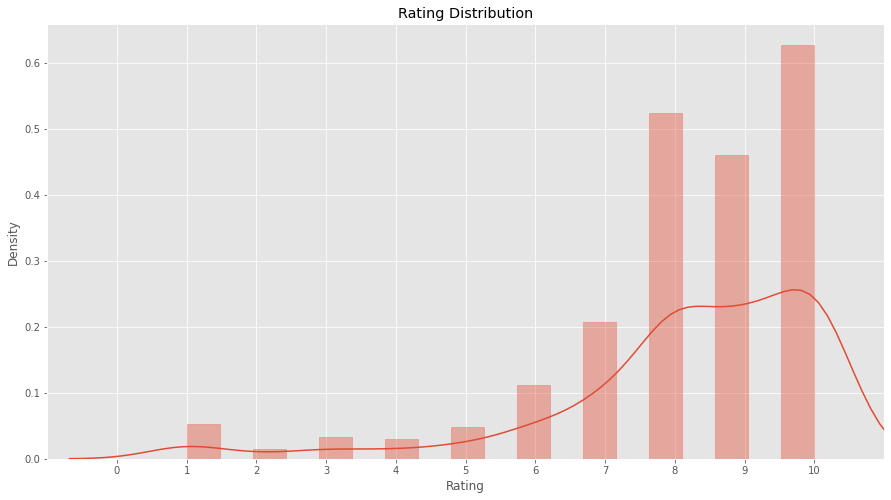

In [147]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 8]

sns.distplot(review_df['Rating'], hist_kws={"rwidth":5,'edgecolor':'red'})
plt.xlim(-1, 11)
plt.xticks(range(11))
plt.ylabel('Density')
plt.title('Rating Distribution')
plt.show()

In [158]:
review_df['Rating'] = review_df['Rating'].apply(lambda x: int(x))
print('Average rating of Train to Busan is {}'.format(round(review_df['Rating'].mean(), 2)))

Average rating of Train to Busan is 8.19
